In [166]:
# Imports, as always...
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

# For generating prime numbers.
from Crypto.Util import number

# Notebook progress bars.
from tqdm.notebook import tqdm

from sqif import CVP, solve_cvp

# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

# Styling for plots.
#plt.style.use('ggplot')
palette = 'deep'
sns.set_theme(style='darkgrid', palette=palette)

In [10]:
def give_me_a_blank_results_dataframe():
    return pd.DataFrame(
        {
            'Bit-length' : [],
            'Lattice Dimension' : [],
            'N' : [],
            'l' : [],
            'c' : [],
            '|b_op - t|^2' : [],
            'P(b_op)' : [],
            '|v_best - t|^2' : [],
            'P(v_best)' : [],
            'P(|v_new - t|^2 < |b_op - t|^2)' : [],
            'P(|v_new - t|^2 > |b_op - t|^2)' : [],
            'E[|v_new - t|^2]' : []
        }
    )

# VQAs for CVP

A very important part of Yan et al. (2022)'s proposal for a quantum-accelerated variant of Schnorr's classical factoring algorithm is that an approximate solution to the closest vector problem (CVP) could be improved upon by considering a superposition over the states forming the unit hypercube around that solution, then using a variational algorithm (they use QAOA) to sample higher quality solutions from that search space.

The relevance of this within the picture of factoring is that we have, by Schnorr's classical factoring method, a sieve-based factoring method requiring sufficiently many "smooth-relation pairs (sr-pairs)" which we may found by reducing the problem to a closest vector problem (CVP) on the prime lattice whose elemental points map to sr-pairs. The higher the quality of our solution to the CVP, the 'better' our sr-pairs are more likely to be, and so we require fewer of them to form a suitable system of equations whose solution yields (part of) a solution to the original factorisation. 

Of course, Schnorr's algorithm is deeply flawed, but that is besides the point -- we know in what ways it is flawed, and why, thanks to works such as Léo Ducas' excellent repository. Our concern, in this notebook, is that *throwing the thing into a variational algorithm is not the silver bullet*; we suggest that Yan et al. (2022)'s proposal is built on a weak claim about lattice dimension, and so we do not expect better results even when using a quantum algorithm to improve the solution to the CVP. Indeed, we doubt their methodology is sophisticated enough to even improve the CVP effectively as the lattice dimension increases, particularly as the lattice dimension is given to scale "sublinearly" based on claims that are not expected to hold.

So, in summary, the purpose of this notebook is to empirically demonstrate that their variational approach, with a Hamiltonian mapped as they describe, offers an insufficient scaling with respect to the probability to sample better solutions to the CVP and lattice dimension, and thus their approach would not scale well even when issues with Schnorr's classical approach are not fundamental (which, unfortunately, they are).

**Hopefully, we can also try out a few other quantum heuristics (e.g. VQE, AQC-PQC), and maybe even a brute-force search of the entire hyper-cube to demonstrate that the idea of 'searching around the approximate solution on the off chance a rounding operation was not so good' is wholy insufficient to solve a problem as difficult as prime factorisation.**

In [2]:
# The expected quality of the solution.
def expected_dist(solutions, probabilities, t):
    # Compute each solution's distance to the target.
    compute_dist = lambda x : np.linalg.norm(x - t)
    dists = np.apply_along_axis(compute_dist, 1, solutions)
    
    # Take a weighted average over these distances (weighted by their probabilities).
    return np.average(dists, weights=probabilities)

In [3]:
# The probability to measure the best state...
def report_algorithm_effectiveness(solutions, probabilities, approximate_solution, t):
    approximate_quality = np.linalg.norm(approximate_solution - t)
    print(f'Our approximate solution by Babai\'s algorithm has a distance to t of {round(approximate_quality, 3):.3f}.\n')
    
    # First, determine which is the best state! This computation will scale exponentially with problem size, so let's not do this in practice -- just for analysis every once in a while.
    best_dist_to_target = np.inf
    best_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - t)
        
        if dist_to_target < best_dist_to_target:
            best_dist_to_target = dist_to_target
            best_prob = prob
            
    print(f'The closest we get to t is {round(best_dist_to_target, 3):.3f}, which we obtain with a probability {round(best_prob, 3):.3f}.\n')
    
    # The cumulative probability to measure a state corresponding to a solution that is a least as good as b_op...
    better_cum_prob = 0
    worse_cum_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - t)
        
        if dist_to_target < approximate_quality:
            better_cum_prob += prob
        elif dist_to_target > approximate_quality:
            worse_cum_prob += prob
            
    print(f'The probability to obtain a state vector corresponding to a solution that is BETTER than the classically-obtained approximate solution is {round(better_cum_prob, 3):.3f}.')
    print(f'The probability to obtain a state vector corresponding to a solution that is WORSE than the classically-obtained approximate solution is {round(worse_cum_prob, 3):.3f}.\n')
    
    print(f'The EXPECTED distance to t is {expected_dist(solutions, probabilities, cvp.t):.3f}')

In [35]:
# The integer bit-length we'd like to solve for.
n_bits = 48

# Lattice and precision parameters.
l = 1
c = 4

# Generating a prime number for which the above lattice dimension is required.
N = number.getPrime(n_bits)
#N=1961
print(f'Integer to factor: {N}')

# Set up the CVP.
cvp = CVP()
cvp.generate_cvp(N, l=l, c=c, seed=42)
print(f'Lattice dimension: {cvp.m}')

print('\n...')

# Solve it!
solutions, probabilities, approximate_solution = solve_cvp(cvp, n_samples=1000, delta=.75, p=1, min_method='Nelder-Mead', verbose=False)
report_algorithm_effectiveness(solutions, probabilities, approximate_solution, cvp.t)

Integer to factor: 169183578713153
Lattice dimension: 8

...
Our approximate solution by Babai's algorithm has a distance to t of 13.115.

The closest we get to t is 13.115, which we obtain with a probability 0.022.

The probability to obtain a state vector corresponding to a solution that is BETTER than the classically-obtained approximate solution is 0.000.
The probability to obtain a state vector corresponding to a solution that is WORSE than the classically-obtained approximate solution is 0.978.

The EXPECTED distance to t is 16.082


## Running Experiments

In [4]:
# From-scratch QAOA-based "SQIF" algorithm on the generated CVP.
def from_scratch_qaoa_experiment(n_bits, l, c, seed=42, n_samples=1000, delta=.75, p=1):
    N = number.getPrime(n_bits)
    
    # Set up the CVP.
    cvp = CVP()
    cvp.generate_cvp(N, l=l, c=c, seed=seed)
    
    # Solve it!
    solutions, probabilities, approximate_solution = solve_cvp(cvp, n_samples=n_samples, delta=delta, p=p, min_method='Nelder-Mead', verbose=False)
    
    approximate_quality = np.linalg.norm(approximate_solution - cvp.t)
    
    # Determine the quality of the SQIF algorithm's solutions to the CVP (in terms of probability).
    
    # First, determine which is the best state! This computation will scale exponentially with problem size, so let's not do this in practice -- just for analysis every once in a while.
    best_dist_to_target = np.inf
    best_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - cvp.t)
        
        if dist_to_target < best_dist_to_target:
            best_dist_to_target = dist_to_target
            best_prob = prob
    
    # The cumulative probability to measure a state corresponding to a solution that is a least as good as b_op...
    better_cum_prob = 0
    worse_cum_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - cvp.t)
        
        if dist_to_target < approximate_quality:
            better_cum_prob += prob
        elif dist_to_target > approximate_quality:
            worse_cum_prob += prob
            
    return pd.DataFrame(
        {
            'Bit-length' : [N.bit_length()],
            'Lattice Dimension' : [cvp.m],
            'N' : [N],
            'l' : [l],
            'c' : [c],
            '|b_op - t|^2' : [approximate_quality],
            'P(b_op)' : [1 - (better_cum_prob + worse_cum_prob)],
            '|v_best - t|^2' : [best_dist_to_target],
            'P(v_best)' : [best_prob],
            'P(|v_new - t|^2 < |b_op - t|^2)' : [better_cum_prob],
            'P(|v_new - t|^2 > |b_op - t|^2)' : [worse_cum_prob],
            'E[|v_new - t|^2]' : [expected_dist(solutions, probabilities, cvp.t)]
        }
    )

from_scratch_qaoa_experiment(11, l=1, c=1.5)

,Bit-length,Lattice Dimension,N,l,c,|b_op - t|^2,P(b_op),|v_best - t|^2,P(v_best),P(|v_new - t|^2 < |b_op - t|^2),P(|v_new - t|^2 > |b_op - t|^2),E[|v_new - t|^2]
0,11,3,1471,1,1.5,5.477226,0.491,5.477226,0.491,0,0.509,5.828433


### QAOA-based, Independent-training

The SQIF algorithm using a QAOA-based quantum "speed-up" mechanism, independently training and running in each input semi-prime. This is taxing on resources, and only really gives us useful insight into the algorithm as applied as a framework requiring a full training setup for every input, but it is necessary to understand a broad range of input independently under the same framework.

In [14]:
# For reference, with n_bits in [5, 50] and 5 repeats for each, p=1 takes ~5 min, p=2 takes ~30 min, p=3 takes ~75 min.

# Number of QAOA layers.
for p in tqdm(range(1, 4)):
    results = give_me_a_blank_results_dataframe()
    
    # Bit-length for the input semi-prime.
    for n_bits in range(5, 51):
        # How many repeats for each bit-length.
        for _ in range(5):
            experiment_outcome = from_scratch_qaoa_experiment(n_bits, l=1, c=1.5, seed=42, p=p)
            results = pd.concat([results, experiment_outcome])
            
    results.to_csv(f'./results/quantum-accelerated-cvp/qaoa-based-(p={p})-independent-training.csv')

  0%|          | 0/3 [00:00<?, ?it/s]

In [310]:
# Repeating the relatively cheap p=1 many more times.
# For reference, with n_bits in [5, 64] and 50 repeats each, this takes ~1 hour 50 min.  
results = give_me_a_blank_results_dataframe()

for n_bits in tqdm(range(5, 65)):
    for _ in range(50):
        experiment_outcome = from_scratch_qaoa_experiment(n_bits, l=1, c=3, seed=42, p=1)
        results = pd.concat([results, experiment_outcome])
        
results.to_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=1)-independent-training-large.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

## Plotting Results

### QAOA-based, Independent-training

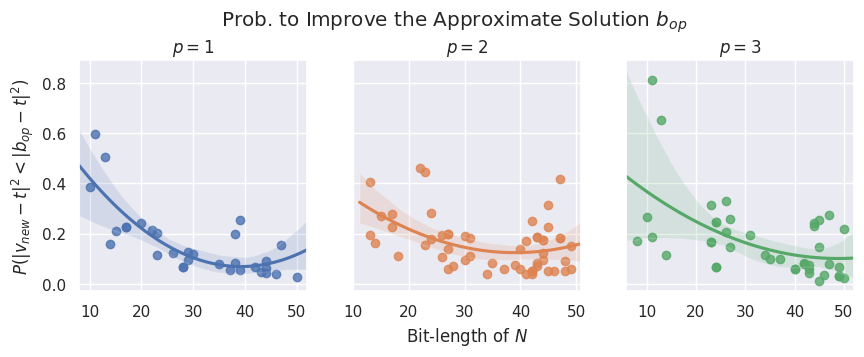

In [288]:
# Set up the figure.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

# Read data.
data_1 = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=1)-independent-training.csv').drop(columns=['Unnamed: 0'])
data_2 = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=2)-independent-training.csv').drop(columns=['Unnamed: 0'])
data_3 = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=3)-independent-training.csv').drop(columns=['Unnamed: 0'])

# Function to take an input semi-prime (and lattice parameter) to its exact lattice dimension.
compute_lattice_dim = lambda N, l: l * np.log2(N) / np.log2(np.log2(N))

# Add 'exact' lattice dimension onto it (so we can differentiate points more easily).
data_1['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(data_1['N'], data_1['l'])
]
data_2['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(data_2['N'], data_2['l'])
]
data_3['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(data_3['N'], data_3['l'])
]

# Drop all failing points (for now).
successful_only_1 = data_1[data_1['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]
successful_only_2 = data_2[data_2['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]
successful_only_3 = data_3[data_3['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1, order=2, ax=ax1, truncate=False, color=sns.color_palette(palette, n_colors=3)[0])
sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2, order=2, ax=ax2, truncate=False, color=sns.color_palette(palette, n_colors=3)[1])
sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3, order=2, ax=ax3, truncate=False, color=sns.color_palette(palette, n_colors=3)[2])

fig.suptitle('Prob. to Improve the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Bit-length of $N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=10, stop=51, step=10))
ax2.set_xticks(np.arange(start=10, stop=51, step=10))
ax3.set_xticks(np.arange(start=10, stop=51, step=10))

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-(sharey-by-p).pdf', bbox_inches='tight')

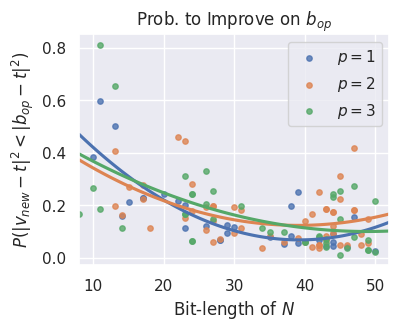

In [120]:
# Chucking the above into a single scatterplot, hued by QAOA-depth.
fig, ax = plt.subplots(figsize=(4, 3))

ax.set_title('Prob. to Improve on $b_{op}$')

marker_size = 15
sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1, order=2, ax=ax, truncate=False, label='$p=1$', ci=False, scatter_kws={'s':marker_size})
sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2, order=2, ax=ax, truncate=False, label='$p=2$', ci=False, scatter_kws={'s':marker_size})
sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3, order=2, ax=ax, truncate=False, label='$p=3$', ci=False, scatter_kws={'s':marker_size})

ax.set_title('Prob. to Improve on $b_{op}$')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Bit-length of $N$')
ax.legend()

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-(hued-by-p).pdf', bbox_inches='tight')

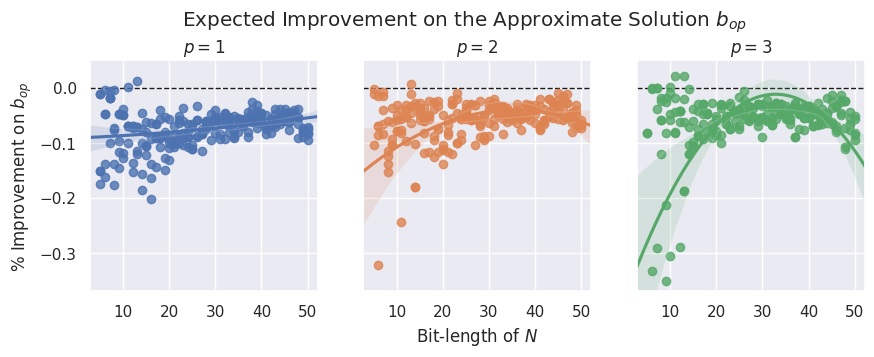

In [165]:
# Compute the expected change in distance to the target vector.
data_1['Expected Improvement'] = (data_1['|b_op - t|^2'] - data_1['E[|v_new - t|^2]']) / data_1['|b_op - t|^2']
data_2['Expected Improvement'] = (data_2['|b_op - t|^2'] - data_2['E[|v_new - t|^2]']) / data_2['|b_op - t|^2']
data_3['Expected Improvement'] = (data_3['|b_op - t|^2'] - data_3['E[|v_new - t|^2]']) / data_3['|b_op - t|^2']

# Set up the figure.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

# It'd be nice to have the boundary between negative and positive improvement highlighted.
ax1.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax2.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax3.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)

sns.regplot(x='Bit-length', y='Expected Improvement', data=data_1, order=2, ax=ax1, truncate=False, color=sns.color_palette(palette, n_colors=3)[0])
sns.regplot(x='Bit-length', y='Expected Improvement', data=data_2, order=2, ax=ax2, truncate=False, color=sns.color_palette(palette, n_colors=3)[1])
sns.regplot(x='Bit-length', y='Expected Improvement', data=data_3, order=2, ax=ax3, truncate=False, color=sns.color_palette(palette, n_colors=3)[2])

fig.suptitle('Expected Improvement on the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('% Improvement on $b_{op}$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Bit-length of $N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=10, stop=51, step=10))
ax2.set_xticks(np.arange(start=10, stop=51, step=10))
ax3.set_xticks(np.arange(start=10, stop=51, step=10))

ax1.set_ylim(-0.37, 0.05)

plt.savefig('./figures/qaoa-based-independent-training/expected-improvement-(sharey-by-p).pdf', bbox_inches='tight')

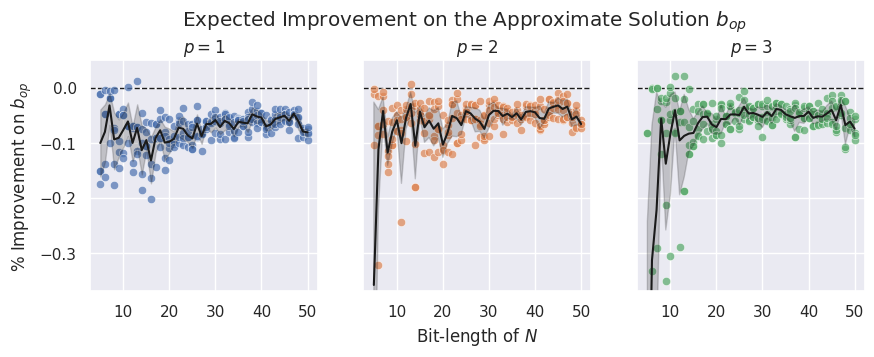

In [180]:
# Compute the expected change in distance to the target vector.
data_1['Expected Improvement'] = (data_1['|b_op - t|^2'] - data_1['E[|v_new - t|^2]']) / data_1['|b_op - t|^2']
data_2['Expected Improvement'] = (data_2['|b_op - t|^2'] - data_2['E[|v_new - t|^2]']) / data_2['|b_op - t|^2']
data_3['Expected Improvement'] = (data_3['|b_op - t|^2'] - data_3['E[|v_new - t|^2]']) / data_3['|b_op - t|^2']

# Set up the figure.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

# It'd be nice to have the boundary between negative and positive improvement highlighted.
ax1.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax2.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax3.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)

sns.scatterplot(x='Bit-length', y='Expected Improvement', data=data_1, ax=ax1, color=sns.color_palette(palette, n_colors=3)[0], alpha=.7)
sns.scatterplot(x='Bit-length', y='Expected Improvement', data=data_2, ax=ax2, color=sns.color_palette(palette, n_colors=3)[1], alpha=.7)
sns.scatterplot(x='Bit-length', y='Expected Improvement', data=data_3, ax=ax3, color=sns.color_palette(palette, n_colors=3)[2], alpha=.7)

sns.lineplot(x='Bit-length', y='Expected Improvement', data=data_1, ax=ax1, color='k')
sns.lineplot(x='Bit-length', y='Expected Improvement', data=data_2, ax=ax2, color='k')
sns.lineplot(x='Bit-length', y='Expected Improvement', data=data_3, ax=ax3, color='k')

fig.suptitle('Expected Improvement on the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('% Improvement on $b_{op}$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Bit-length of $N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=10, stop=51, step=10))
ax2.set_xticks(np.arange(start=10, stop=51, step=10))
ax3.set_xticks(np.arange(start=10, stop=51, step=10))

ax1.set_ylim(-0.37, 0.05)

plt.savefig('./figures/qaoa-based-independent-training/expected-improvement-(scatter-line).pdf', bbox_inches='tight')

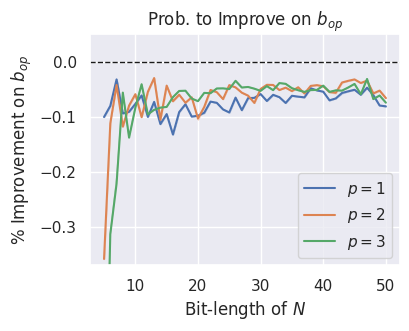

In [194]:
# Chucking the above into a single scatterplot, hued by QAOA-depth.
fig, ax = plt.subplots(figsize=(4, 3))

ax.set_title('Expected Improvement on $b_{op}$')

data_1['p'] = ['$p=1$'] * len(data_1)
data_2['p'] = ['$p=2$'] * len(data_2)
data_3['p'] = ['$p=3$'] * len(data_3)

data_all = pd.concat([data_1, data_2, data_3])

sns.lineplot(x='Bit-length', y='Expected Improvement', data=data_all, hue='p', ci=False, palette=palette)

ax.set_title('Prob. to Improve on $b_{op}$')
ax.set_ylabel('% Improvement on $b_{op}$')
ax.set_xlabel('Bit-length of $N$')

ax.legend()

ax.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax.set_ylim(-0.37, 0.05)

plt.savefig('./figures/qaoa-based-independent-training/expected-improvement-(line-hued-by-p).pdf', bbox_inches='tight')

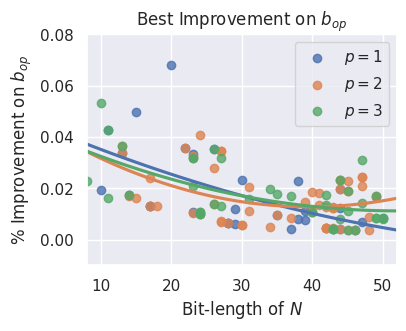

In [219]:
# Chucking the above into a single scatterplot, hued by QAOA-depth.
fig, ax = plt.subplots(figsize=(4, 3))

# Compute the best change in distance to the target vector.
data_all['Best Improvement'] = (data_all['|b_op - t|^2'] - data_all['|v_best - t|^2']) / data_all['|b_op - t|^2']

# Drop all failing points (for now).
successful_only_all = data_all[data_all['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

sns.regplot(x='Bit-length', y='Best Improvement', data=successful_only_all[successful_only_all['p'] == '$p=1$'], order=2, ax=ax, truncate=False, color=sns.color_palette(palette, n_colors=3)[0], ci=False, label='$p=1$')
sns.regplot(x='Bit-length', y='Best Improvement', data=successful_only_all[successful_only_all['p'] == '$p=2$'], order=2, ax=ax, truncate=False, color=sns.color_palette(palette, n_colors=3)[1], ci=False, label='$p=2$')
sns.regplot(x='Bit-length', y='Best Improvement', data=successful_only_all[successful_only_all['p'] == '$p=3$'], order=2, ax=ax, truncate=False, color=sns.color_palette(palette, n_colors=3)[2], ci=False, label='$p=3$')

ax.set_title('Best Improvement on $b_{op}$')
ax.set_ylabel('% Improvement on $b_{op}$')
ax.set_xlabel('Bit-length of $N$')

ax.legend()

ax.set_ylim(-.01, 0.08)

plt.savefig('./figures/qaoa-based-independent-training/best-improvement-(hued-by-p).pdf', bbox_inches='tight')

We'll now fit these data to the curve $y=1/2^{\alpha x}$ by minimising this sum of the squared residuals with an optimal choice for $\alpha$. This gives us a measure for the scaling of $y$ with respect to $x$, assuming it scales exponentially.

We are most interested in whether the SQIF algorithm can improve the approximate solution to the CVP in such a way that it scales effectively as the lattice dimension increases. In particular, if we can fit the curve with $\alpha<1$, then the scaling is not exponential as suspected.

In [229]:
# Additional imports.
from scipy.optimize import curve_fit, least_squares

In [297]:
# Scaling to fit to.
def scaling_function(x, alpha):
    return 1 / (2 ** (alpha * x ))

# Define the x- and y-data.
x_data_successful_1 = successful_only_1['Bit-length']
y_data_successful_1 = successful_only_1['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_successful_2 = successful_only_2['Bit-length']
y_data_successful_2 = successful_only_2['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_successful_3 = successful_only_3['Bit-length']
y_data_successful_3 = successful_only_3['P(|v_new - t|^2 < |b_op - t|^2)']

x_data_1 = data_1['Bit-length']
y_data_1 = data_1['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_2 = data_2['Bit-length']
y_data_2 = data_2['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_3 = data_3['Bit-length']
y_data_3 = data_3['P(|v_new - t|^2 < |b_op - t|^2)']

# Fit the curve to find an optimal alpha.
params_successful_1 = curve_fit(scaling_function, x_data_successful_1, y_data_successful_1)[0]
alpha_successful_1 = params_successful_1[0]
params_successful_2 = curve_fit(scaling_function, x_data_successful_2, y_data_successful_2)[0]
alpha_successful_2 = params_successful_2[0]
params_successful_3 = curve_fit(scaling_function, x_data_successful_3, y_data_successful_3)[0]
alpha_successful_3 = params_successful_3[0]

params_1 = curve_fit(scaling_function, x_data_1, y_data_1)[0]
alpha_1 = params_1[0]
params_2 = curve_fit(scaling_function, x_data_2, y_data_2)[0]
alpha_2 = params_2[0]
params_3 = curve_fit(scaling_function, x_data_3, y_data_3)[0]
alpha_3 = params_3[0]

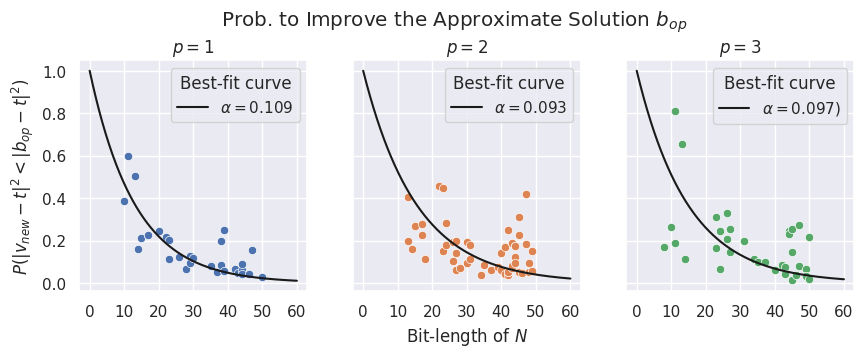

In [301]:
# Set up the figure.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

# Scatters.
sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1, ax=ax1, color=sns.color_palette(palette, n_colors=3)[0])
sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2, ax=ax2, color=sns.color_palette(palette, n_colors=3)[1])
sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3, ax=ax3, color=sns.color_palette(palette, n_colors=3)[2])

# Fitted curves.
step_size = .1
xs = np.arange(start=0, stop=60+step_size, step=step_size)
ys_successful_1 = [scaling_function(x, alpha_successful_1) for x in xs]
ys_successful_2 = [scaling_function(x, alpha_successful_2) for x in xs]
ys_successful_3 = [scaling_function(x, alpha_successful_3) for x in xs]
#ys_1 = [scaling_function(x, alpha_1) for x in xs]
#ys_2 = [scaling_function(x, alpha_2) for x in xs]
#ys_3 = [scaling_function(x, alpha_3) for x in xs]

sns.lineplot(x=xs, y=ys_successful_1, color='k', ax=ax1, label=f'$\\alpha={alpha_successful_1:.3f}$')
sns.lineplot(x=xs, y=ys_successful_2, color='k', ax=ax2, label=f'$\\alpha={alpha_successful_2:.3f}$')
sns.lineplot(x=xs, y=ys_successful_3, color='k', ax=ax3, label=f'$\\alpha={alpha_successful_3:.3f}$)')
#sns.lineplot(x=xs, y=ys_1, color='k', ax=ax1, linestyle='--', label=f'$\\alpha={alpha_1:.3f}$')
#sns.lineplot(x=xs, y=ys_2, color='k', ax=ax2, linestyle='--', label=f'$\\alpha={alpha_2:.3f}$')
#sns.lineplot(x=xs, y=ys_3, color='k', ax=ax3, linestyle='--', label=f'$\\alpha={alpha_3:.3f}$')

fig.suptitle('Prob. to Improve the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Bit-length of $N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=0, stop=61, step=10))
ax2.set_xticks(np.arange(start=0, stop=61, step=10))
ax3.set_xticks(np.arange(start=0, stop=61, step=10))

ax1.legend(title='Best-fit curve')
ax2.legend(title='Best-fit curve')
ax3.legend(title='Best-fit curve')

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-fit-curves-(sharey-by-p).pdf', bbox_inches='tight')

Using the larger datasets to improve the accuracy of our figures and analyses.

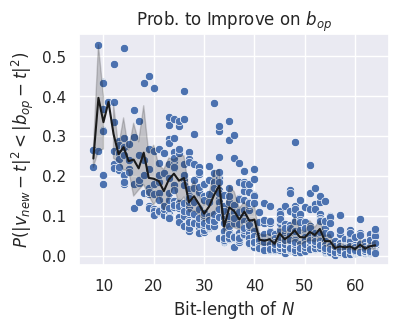

In [325]:
fig, ax = plt.subplots(figsize=(4, 3))

data_1_large = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=1)-independent-training-large.csv').drop(columns='Unnamed: 0')

successful_only_1_large = data_1_large[data_1_large['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1_large, ax=ax, color=sns.color_palette(palette, n_colors=3)[0])
sns.lineplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1_large, ax=ax, color='k')

ax.set_title('Prob. to Improve on $b_{op}$')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Bit-length of $N$')

ax.set_xticks(np.arange(start=10, stop=65, step=10))

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-(p=1)-large.pdf', bbox_inches='tight')

In [326]:
x_data_successful_1_large = successful_only_1_large['Bit-length']
y_data_successful_1_large = successful_only_1_large['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_1_large = data_1_large['Bit-length']
y_data_1_large = data_1_large['P(|v_new - t|^2 < |b_op - t|^2)']

params_successful_1_large = curve_fit(scaling_function, x_data_successful_1_large, y_data_successful_1_large)[0]
alpha_successful_1_large = params_successful_1_large[0]

params_1_large = curve_fit(scaling_function, x_data_1_large, y_data_1_large)[0]
alpha_1_large = params_1_large[0]

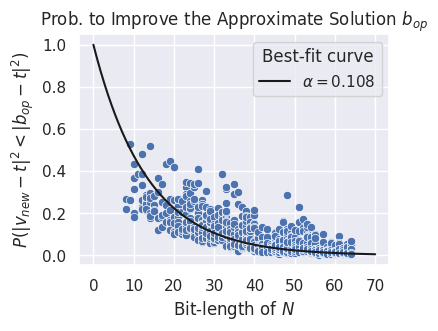

In [329]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1_large, ax=ax, color=sns.color_palette(palette, n_colors=3)[0])

# Fitted curves.
step_size = .1
xs_large = np.arange(start=0, stop=70+step_size, step=step_size)
ys_successful_1_large = [scaling_function(x, alpha_successful_1_large) for x in xs_large]
#ys_1 = [scaling_function(x, alpha_1) for x in xs]

sns.lineplot(x=xs_large, y=ys_successful_1_large, color='k', ax=ax, label=f'$\\alpha={alpha_successful_1_large:.3f}$')
#sns.lineplot(x=xs, y=ys_3, color='k', ax=ax3, linestyle='--', label=f'$\\alpha={alpha_3:.3f}$')

ax.set_title('Prob. to Improve the Approximate Solution $b_{op}$')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Bit-length of $N$')
ax.set_xticks(np.arange(start=0, stop=75, step=10))

ax.legend(title='Best-fit curve')

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-fit-curves-(p=1)-large.pdf', bbox_inches='tight')

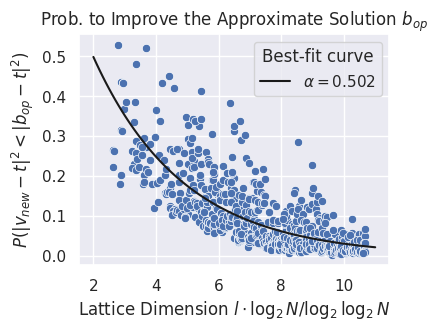

In [344]:
fig, ax = plt.subplots(figsize=(4, 3))

compute_lattice_dim = lambda N, l: l * np.log2(N) / np.log2(np.log2(N))
successful_only_1_large['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(successful_only_1_large['N'], successful_only_1_large['l'])
]

sns.scatterplot(x='Exact Lattice Dimension', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1_large, ax=ax, color=sns.color_palette(palette, n_colors=3)[0])

x_data_successful_1_large = successful_only_1_large['Exact Lattice Dimension']
y_data_successful_1_large = successful_only_1_large['P(|v_new - t|^2 < |b_op - t|^2)']

params_successful_1_large = curve_fit(scaling_function, x_data_successful_1_large, y_data_successful_1_large)[0]
alpha_successful_1_large = params_successful_1_large[0]

step_size = .1
xs_large = np.arange(start=2, stop=11+step_size, step=step_size)
ys_successful_1_large = [scaling_function(x, alpha_successful_1_large) for x in xs_large]
#ys_1 = [scaling_function(x, alpha_1) for x in xs]

sns.lineplot(x=xs_large, y=ys_successful_1_large, color='k', ax=ax, label=f'$\\alpha={alpha_successful_1_large:.3f}$')
#sns.lineplot(x=xs, y=ys_3, color='k', ax=ax3, linestyle='--', label=f'$\\alpha={alpha_3:.3f}$')

ax.set_title('Prob. to Improve the Approximate Solution $b_{op}$')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Lattice Dimension $l\cdot\log_2N/\log_2\log_2N$')
ax.set_xticks(np.arange(start=2, stop=11, step=2))

ax.legend(title='Best-fit curve')

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-(wrt-lattice-dim)-fit-curves-(p=1)-large.pdf', bbox_inches='tight')